## Import libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
from collections import defaultdict
import csv
from datetime import datetime
import os

## Read and preprocess data


In [34]:
def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

# Load data for each file

file_names = ["DataSeating 2024.csv","22Oct.csv","23Oct.csv","24Oct.csv","30Oct.csv", "5Nov.csv", "7Nov.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Oct21, Oct22,Oct23, Oct24, Oct30, Nov5, Nov7= [load_data(os.path.join(data_directory, file)) for file in file_names]

Transforming data to access each passenger's Id

First we solved the problem for November 5th, then we'll have to automate it

In [35]:
Passengers = {}
j = 1

for group_num, data in Nov5.items():
    weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 10000}  # Weight per passenger
    
    # Extracting data
    femmes, hommes, wchr, total_minutes = data
    
    # Enumerating passengers
    for _ in range(femmes + hommes + wchr):
        if femmes > 0:
            weight = weights['Femmes']  
            Passengers[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight, 'connection_time': total_minutes}
            femmes -= 1
        elif hommes > 0:
            weight = weights['Hommes']
            Passengers[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight, 'connection_time': total_minutes}
            hommes -= 1
        else:
            weight = weights['WCHR']
            Passengers[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight, 'connection_time': total_minutes}
            wchr -= 1
        j += 1

print(Passengers)

{1: {'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}, 2: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 3: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 4: {'gender': 'Hommes', 'group': 2, 'weight': 85, 'connection_time': 60}, 5: {'gender': 'Femmes', 'group': 3, 'weight': 70, 'connection_time': 165}, 6: {'gender': 'Hommes', 'group': 3, 'weight': 85, 'connection_time': 165}, 7: {'gender': 'Femmes', 'group': 4, 'weight': 70, 'connection_time': 0}, 8: {'gender': 'Hommes', 'group': 4, 'weight': 85, 'connection_time': 0}, 9: {'gender': 'WCHR', 'group': 4, 'weight': 10000, 'connection_time': 0}, 10: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 11: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 12: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 13: {'gender': 'Femmes', 'group': 6, 'weight': 70, 'connection_time': 0}, 14: {'gender': 'Hommes', 'group': 6, 'we

# Static model

In [36]:
ranks = 29 #number of rows in the aircraft
np = len(Passengers) #number of passengers - TO BE CHANGED
ns=7*ranks #number of seats

def modele_statique():
    m=Model('statique') # Model initialization
    
    # -- Adding variables  --
    # Sij : dict[(int, int) : Var] : Associate passenger i with seat j
    S = {(i,j) : m.addVar(vtype = GRB.BINARY, name = f'j{i}') for i in range(1, np+1) for j in range (1, ns+1)}

    # -- Adding constraints  --
    
    # Max. 1 seat per passenger
    for j in range (1, ns+1):
        m.addConstr(quicksum(S[(i,j)] for i in range (1, np+1)) <=1, name="PassengerMax")

    #Each passenger has one and only one seat
    for i in range (1, np+1):
        m.addConstr(quicksum(S[(i,j)] for j in range (1, ns+1)) == 1, name="SeatMax")
        
    #The central aisle is left free   
    for i in range (1, np+1):
        for j in range (1, ns+1):
            if j%7==4 : 
                m.addConstr(S[(i, j)] == 0)

    #Baricenter
    
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(Passengers[i]['weight'] for i in range(1, np + 1)).getValue()

    for i in range(1, np + 1):
        
        j_k=1

        for j in range(1, ns + 1):
            
            weight_ij = Passengers[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k=j_k+1
         

            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7)  + 1 )* S[i, j] * weight_ij)
                
    

    m.addConstr(x_g >= 3)  
    m.addConstr(x_g <= 5)  
    
    m.addConstr(y_g >= 13)  
    m.addConstr(y_g <= 17)


    #Disabled passengers occupy 4 spaces on the central aisle
    for passenger in Passengers:
        if Passengers[passenger]['gender']=='WCHR':
            #Seats are shortened by row (from 7 to 7)
            for j in range(1, ns+1-8, 7):             
            
                x1, x2, x3, x4, x5, x6, x7 = j,j+1,j+2,j+3,j+4,j+5,j+6
                
                #A seat is fixed in rows 3 or 5.
                m.addConstr(S[(passenger, x1)] + S[(passenger, x2)] +  S[(passenger, x6)] + S[(passenger, x7)] ==0 )   
                
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3-1)] for i in Passengers) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+7)] for i in Passengers) <= 1) 
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+6)] for i in Passengers) <= 1)
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+1)] for i in Passengers) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+7)] for i in Passengers) <= 1) 
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+8)] for i in Passengers) <= 1)
            #Disabled passengers cannot be in the last row   
            m.addConstr(sum(S[(passenger, k)] for k in range (ns-6, ns+1)) == 0)  
    return m, S

In [37]:
m,S=modele_statique()

Objective functions

In [38]:
#Transit passengers are seated at the front of the aircraft

def obj_transit():
    T= {} 
    
    for passenger in Passengers:
        if Passengers[passenger]['connection_time'] >0:   #transit passenger
            T[passenger]=Passengers[passenger]['connection_time']

    #T=sorted(T.items(), key=lambda item:item[1], reverse=True)
    P=list(T.keys())  #returns a list of transit passenger identifiers
    

    f=0
    for k in range (len(P)):
        for j in range (1, ns+1):
            q=(j-1)//7
            f+= S[(P[k],j)] * (1/T[P[k]]) * q
            

    return f

m.setObjective(obj_transit(), GRB.MINIMIZE)

In [39]:
def seat_coordinates(seat):
    coordinates = []
    for j in range(len(seat)):
        if (seat[j] % 7 == 0):
            x = 7
            y = (seat[j] // 7) 
        else:
            x = seat[j] % 7
            y = (seat[j] // 7) +1 
        coordinates.append((x, y))
    return coordinates

In [40]:
alpha=0.8

def obj_dist(alpha):

    obj = LinExpr()
    for i in range(1, np + 1):
        for k in range(i + 1, np + 1):  
            if  i!=k and Passengers[i]['group'] == Passengers[k]['group']:  

                xi, yi = seat_coordinates([j for j in range(1, ns + 1) if S[(i, j)].x])[0]  
                xk, yk = seat_coordinates([j for j in range(1, ns + 1) if S[(k, j)].x])[0]  
                dist_x = abs(xi - xk)  
                dist_y = abs(yi - yk)  
                obj += alpha*dist_x + (1-alpha)*dist_y  
                
    return obj


#m.setObjective(obj_dist(alpha), GRB.MINIMIZE) # solve problem with linearization

In [41]:
# -- Choice of minimalist display settings --
m.params.outputflag = 0 # mute mode

# -- Model update --
m.update() 

# -- Text mode display of PL --
display(m)

<gurobi.Model MIP instance statique: 3905 constrs, 19691 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [42]:
# -- Resolution --
m.optimize()

# -- Solution display --
print("Seats on the plane are as follows :", [(i,j) for i in range(1,np+1) for j in range (1,ns+1) if S[(i,j)].x])

Seats on the plane are as follows : [(1, 42), (2, 112), (3, 140), (4, 2), (5, 26), (6, 22), (7, 66), (8, 113), (9, 192), (10, 59), (11, 121), (12, 50), (13, 84), (14, 152), (15, 15), (16, 17), (17, 164), (18, 8), (19, 1), (20, 3), (21, 6), (22, 52), (23, 29), (24, 83), (25, 101), (26, 71), (27, 202), (28, 133), (29, 157), (30, 51), (31, 97), (32, 14), (33, 55), (34, 76), (35, 99), (36, 98), (37, 87), (38, 162), (39, 183), (40, 171), (41, 145), (42, 105), (43, 85), (44, 176), (45, 156), (46, 126), (47, 64), (48, 196), (49, 120), (50, 19), (51, 16), (52, 12), (53, 35), (54, 119), (55, 168), (56, 127), (57, 118), (58, 92), (59, 27), (60, 49), (61, 89), (62, 163), (63, 124), (64, 174), (65, 159), (66, 13), (67, 9), (68, 169), (69, 73), (70, 5), (71, 7), (72, 201), (73, 190), (74, 134), (75, 108), (76, 187), (77, 24), (78, 38), (79, 28), (80, 44), (81, 161), (82, 36), (83, 70), (84, 91), (85, 20), (86, 21), (87, 10), (88, 94), (89, 178), (90, 106), (91, 203), (92, 180), (93, 40), (94, 56), 

Visualization of the seats

In [43]:
# Creating a variable called seats containing only the j coordinates
seats = [j for i in range(1, np + 1) for j in range(1, ns + 1) if S[(i, j)].x]
seat_coords = seat_coordinates(seats)

# Display the Baricenter

def calculate_center_of_mass(seat_coords, Passengers):
    x_g = LinExpr()
    y_g = LinExpr()
    total_weight = quicksum(Passengers[i]['weight'] for i in range(1, np + 1)).getValue()

    for i in range(1, np + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = Passengers[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    return x_g, y_g

x_g, y_g = calculate_center_of_mass(seat_coords, Passengers)


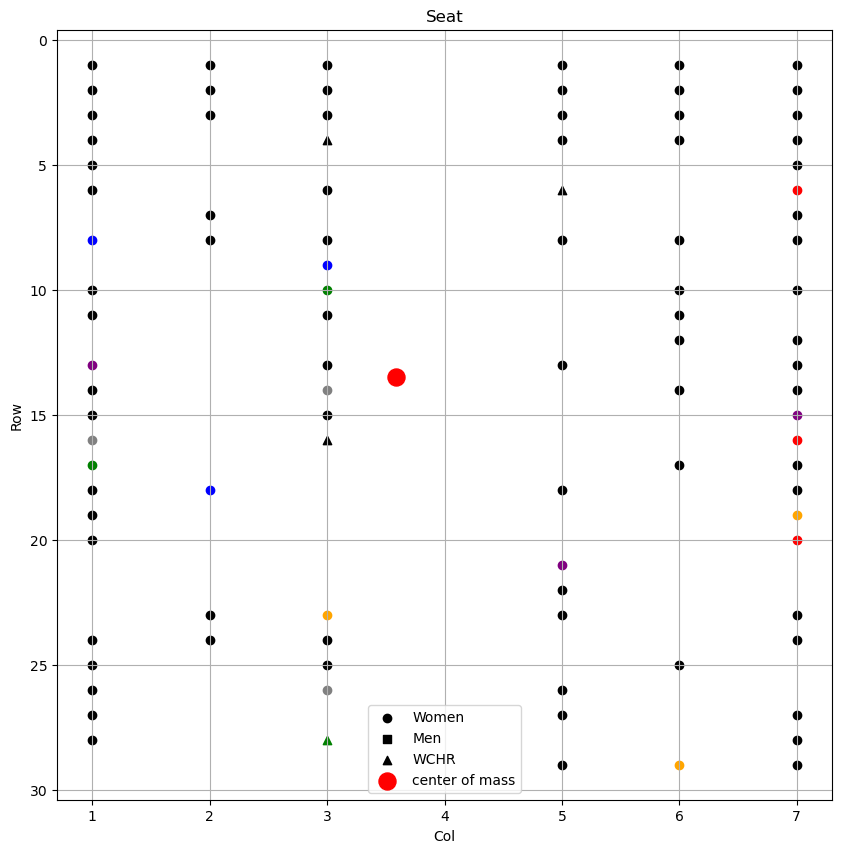

In [44]:
# Counting the frequency of each group
group_counts = defaultdict(int)

for passenger in Passengers.values():
    group_counts[passenger['group']] += 1

# Sort the groups by the number of passengers in each group in descending order
sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

# Print the groups in ascending order with the number of passengers in each group
#print("Groups in ascending order with the number of passengers in each group:")
#for group, count in sorted_groups:
#    print(f"Group {group}: {count} passengers")

# Define shapes for each gender
shapes = {
    'Women': 'o',   # Circule
    'Men': 's',   # Square
    'WCHR': '^'      # Triangule
}

# Define colors for the groups with 3 passangers
colors = {
    1: 'red',
    4: 'green',
    5: 'blue',
    14: 'orange',
    23: 'purple',
    46: 'gray'
}

plt.figure(figsize=(10, 10))
for idx, coord in enumerate(seat_coords):
    group = Passengers[idx + 1]['group']
    gender = Passengers[idx + 1]['gender']
    color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
    shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
    plt.scatter(coord[0], coord[1], color=color, marker=shape)  # Use marker parameter to set the shape
    
# Add labels for each gender
for gender, shape in shapes.items():
    plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

# Plotting the center of mass
plt.scatter(x_g.getValue(), y_g.getValue(), color='red', marker='o', label = "center of mass" , s=150)  # Larger red point for center of mass

plt.xlabel('Col')
plt.ylabel('Row')
plt.title('Seat')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend() 
plt.show()
